# Vanilla GAN

This is the most basic GAN architecutre introduced by Goodfellow in his seminal paper. 

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


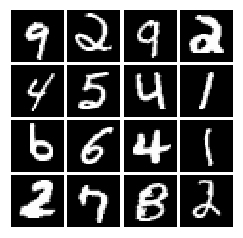

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)


## Discriminator
Our first step is to build a discriminator. We will use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [4]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        layer_1 = tf.layers.dense(x, 256, tf.nn.leaky_relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 256, tf.nn.leaky_relu, name="layer_2")
        logits = tf.layers.dense(layer_2, 1, name="logit")
        return logits

## Generator
Now to build a generator. We will again use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [5]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        layer_1 = tf.layers.dense(z, 1024, tf.nn.relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 1024, tf.nn.relu, name="layer_2")
        img = tf.layers.dense(layer_2, 784, tf.nn.tanh, name="image")
        return img

# GAN Loss

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [6]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    ones_labels_d = tf.ones_like(logits_real) 
    zeros_labels_d = tf.zeros_like(logits_fake)
    
    ones_labels_g = tf.ones_like(logits_fake)
    
    real_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones_labels_d)
    fake_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros_labels_d)
    D_loss = tf.reduce_mean(real_data_predictions) + tf.reduce_mean(fake_data_predictions)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones_labels_g))
    return D_loss, G_loss

# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if we set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [7]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.

In [8]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch_x})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

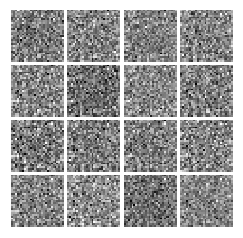


Iter: 0, D: 2.3, G:0.7526
Iter: 50, D: 0.8474, G:1.29
Iter: 100, D: 0.9101, G:0.8756
Iter: 150, D: 1.418, G:1.464
Iter: 200, D: 1.011, G:1.89


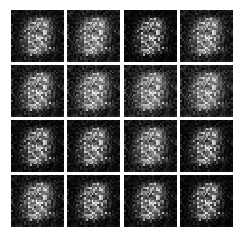


Iter: 250, D: 1.24, G:1.104
Iter: 300, D: 0.6765, G:2.156
Iter: 350, D: 1.136, G:0.932
Iter: 400, D: 1.11, G:2.045
Iter: 450, D: 1.116, G:2.382


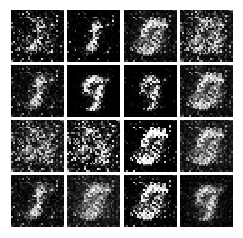


Iter: 500, D: 0.8797, G:1.034
Iter: 550, D: 1.155, G:1.258
Iter: 600, D: 1.037, G:1.544
Iter: 650, D: 1.236, G:1.242
Iter: 700, D: 1.104, G:1.973


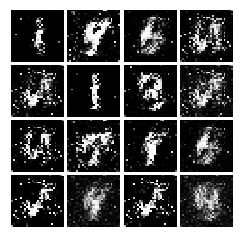


Iter: 750, D: 1.049, G:1.192
Iter: 800, D: 1.276, G:1.102
Iter: 850, D: 1.214, G:0.887
Iter: 900, D: 1.116, G:1.564
Iter: 950, D: 1.107, G:1.225


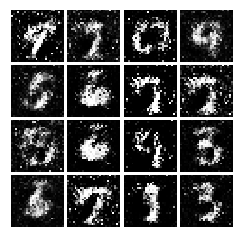


Iter: 1000, D: 0.9974, G:1.233
Iter: 1050, D: 1.254, G:1.107
Iter: 1100, D: 1.155, G:1.25
Iter: 1150, D: 1.093, G:1.261
Iter: 1200, D: 1.203, G:1.19


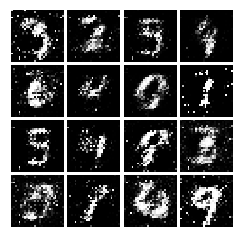


Iter: 1250, D: 1.193, G:1.377
Iter: 1300, D: 1.181, G:1.336
Iter: 1350, D: 1.119, G:1.308
Iter: 1400, D: 1.429, G:1.064
Iter: 1450, D: 1.16, G:1.229


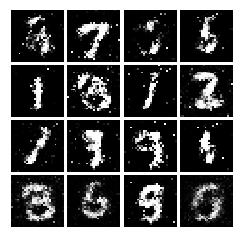


Iter: 1500, D: 1.206, G:0.9389
Iter: 1550, D: 1.296, G:1.034
Iter: 1600, D: 1.251, G:1.101
Iter: 1650, D: 1.37, G:0.939
Iter: 1700, D: 1.321, G:1.09


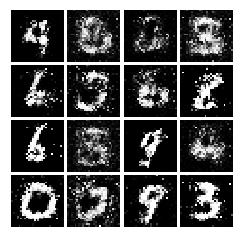


Iter: 1750, D: 1.364, G:0.8061
Iter: 1800, D: 1.253, G:0.8259
Iter: 1850, D: 1.308, G:0.8318
Iter: 1900, D: 1.312, G:0.9433
Iter: 1950, D: 1.288, G:0.8


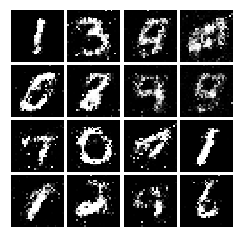


Iter: 2000, D: 1.256, G:1.063
Iter: 2050, D: 1.407, G:0.6099
Iter: 2100, D: 1.241, G:0.8721
Iter: 2150, D: 1.315, G:0.6444
Iter: 2200, D: 1.303, G:1.034


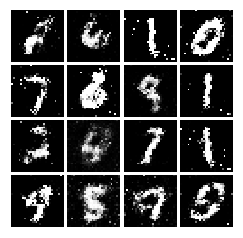


Iter: 2250, D: 1.223, G:1.256
Iter: 2300, D: 1.484, G:1.02
Iter: 2350, D: 1.33, G:0.7911
Iter: 2400, D: 1.32, G:0.8329
Iter: 2450, D: 1.16, G:1.121


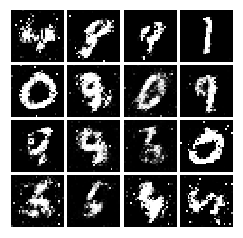


Iter: 2500, D: 1.359, G:0.7736
Iter: 2550, D: 1.386, G:0.9266
Iter: 2600, D: 1.335, G:0.8474
Iter: 2650, D: 1.183, G:0.8745
Iter: 2700, D: 1.329, G:1.064


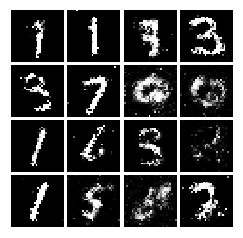


Iter: 2750, D: 1.252, G:0.8806
Iter: 2800, D: 1.41, G:1.013
Iter: 2850, D: 1.351, G:0.884
Iter: 2900, D: 1.4, G:0.8244
Iter: 2950, D: 1.443, G:1.1


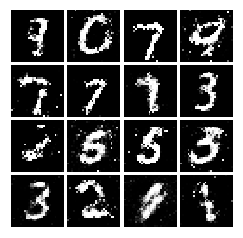


Iter: 3000, D: 1.291, G:0.998
Iter: 3050, D: 1.23, G:1.007
Iter: 3100, D: 1.242, G:0.8884
Iter: 3150, D: 1.215, G:0.8273
Iter: 3200, D: 1.278, G:0.9


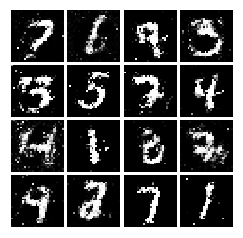


Iter: 3250, D: 1.262, G:0.9281
Iter: 3300, D: 1.26, G:0.8845
Iter: 3350, D: 1.306, G:0.9953
Iter: 3400, D: 1.325, G:0.7813
Iter: 3450, D: 1.3, G:1.057


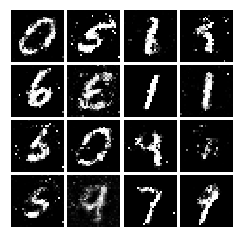


Iter: 3500, D: 1.291, G:0.833
Iter: 3550, D: 1.311, G:0.8638
Iter: 3600, D: 1.326, G:0.7127
Iter: 3650, D: 1.359, G:0.8619
Iter: 3700, D: 1.328, G:0.8759


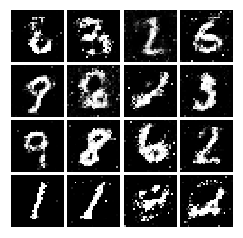


Iter: 3750, D: 1.331, G:0.8007
Iter: 3800, D: 1.417, G:0.9403
Iter: 3850, D: 1.327, G:0.7953
Iter: 3900, D: 1.393, G:0.8288
Iter: 3950, D: 1.318, G:0.9101


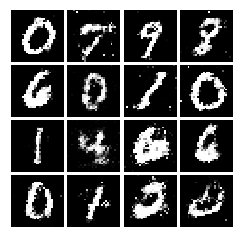


Iter: 4000, D: 1.35, G:1.11
Iter: 4050, D: 1.233, G:0.9948
Iter: 4100, D: 1.331, G:0.724
Iter: 4150, D: 1.314, G:0.7893
Iter: 4200, D: 1.288, G:0.886


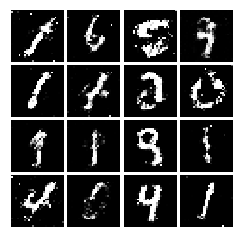


Iter: 4250, D: 1.376, G:0.6228
Final images


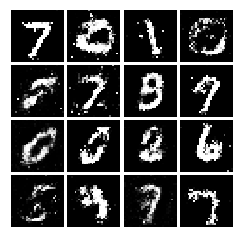

In [11]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)